**<h1 style ='text-align:center;'>Assignment-2 Brains</h1>**

## **Problem Statement 1: Trade Logic & Risk Control Basics**

### 1. What does leverage less than 1 mean? Does it normally make financial sense? Think of its utility/applicability in our backtesting engine, if any.

**Ans**: Leverage means, `Position_size/Capital`, hence leverage less than 1 means that the Position Size is less than the capital.
- Hence, it makes a lot of financial sense.
- It implies partial use of capital that is very useful for risk-averse trading.
- By this we take smaller positions which implies smaller profits but also also smaller losses.
- This can help in backtesting engine by helping us to analyse multiple strategies, by splitting our capital accordingly.

### 2. Explain the difference between a static stop loss and a trailing stop loss in the context of trade risk management. Discuss how each behaves in a trending market versus a volatile market.

**Ans**: Static stop-loss remains at a fixed value, whereas the trailing stop loss increases(never decreases) along with the increase in price of stock. So in the context of risk management, the maximum loss will be same in both the cases, but the trailing stop-loss helps us in booking lesser losses or even profits. 
- In trending market, as the market does not fluctuate much, the chances of stop loss getting triggered is less and hence trailing stop-loss is better here
- Whereas, in volatile markets, the market fluctuates a lot and hence the chances of triggering a stop loss is high therefore trailing stop losses tend to be triggered faster(as their value increases and market is fluctuating a lot), hence we can book a loss even if prices are about to increase after some time. Therefore in such a situation I would prefer to have normal stop-loss.

### 3. Analyze whether implementing a trailing take profit is necessary. Is its behavior captured by some other already defined risk management method? If yes, then name it.

**Ans**:No, its not necessary to implement a trailing take profit, as it's behavious is already captured by trailing stop loss.

### 4. In what scenarios can a trade remain open even after the price falls below the set stop-loss level?

**Ans**:The trade can remain open even after the price falls below the set stoploss level due to the following reasons :
- Network issues
- Broker API delays
- Code bugs
- In case we place a stop Limit order instead of a Stop Market order,
  For example, if price to trigger is 95, and sell at 94 or above(limit order) and market falls from 95 to 90 immediately then there are no buyers at 94-95 range, hence trade remains open!  

## **Problem Statement 2: Probabilistic Pattern Validator**

### 1. Pattern Identification: For each of the specified candlestick patterns, scan a given OHLCV dataset and locate all occurrences of the pattern. Use data from any NSE-listed stock of your choice, covering a period of the last 5 years.

In [2]:
!pip install yfinance plotly mplfinance --quiet

import yfinance as yf
import mplfinance as mpf
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import plotly.subplots as sp
import matplotlib.pyplot as plt
import statistics

In [3]:
# Set some display options
plt.style.use('seaborn-v0_8-darkgrid')
pd.set_option('display.max_columns', None)

In [4]:
!pip install yfinance plotly --quiet

import yfinance as yf
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from datetime import datetime

# Download OHLCV data
# ticker = 'ICICIBANK.NS'
# end = datetime(year=2025, month=3, day=1)
# start = datetime(year=2024, month=3, day=1)
# interval = '1d'
def download_flat_yf(ticker, start, end, interval):
    data = yf.download(ticker, start=start, end=end, interval=interval, progress=False)
    if isinstance(data.columns, pd.MultiIndex):
        data = data.xs(ticker, axis=1, level=1)

    data.columns.name = None
    data.reset_index(inplace=True)
    data.columns = [col.lower() for col in data.columns]
    if data.columns[0] in ['date', 'datetime']:
        data.rename(columns={data.columns[0]: 'datetime'}, inplace=True)
    data.loc[:,'datetime'] = pd.to_datetime(data['datetime'])

    return data

stock_symbol = 'ICICIBANK.NS'
data = download_flat_yf(stock_symbol, start='2020-06-01', end='2025-06-01', interval='1wk')
data.head()


YF.download() has changed argument auto_adjust default to True


,datetime,close,high,low,open,volume
0,2020-06-01,345.290497,360.563692,321.414015,327.697297,255584954
1,2020-06-08,332.723938,361.288691,313.294092,354.328736,215250270
2,2020-06-15,351.670410,353.265421,314.647395,329.823948,228772054
3,2020-06-22,337.460541,367.330287,327.213953,354.763725,235081694
4,2020-06-29,348.963776,358.533690,327.213956,333.738902,191576311


In [5]:
def is_bullish_engulfing(data, i):
    prev = data.iloc[i - 1]
    curr = data.iloc[i]
    return (
        prev['close'] < prev['open'] and
        curr['close'] > curr['open'] and
        curr['open'] < prev['close'] and
        curr['close'] > prev['open']
    )

In [6]:
def is_bearish_engulfing(data, i):
    prev = data.iloc[i - 1]
    curr = data.iloc[i]
    return (
        prev['close'] > prev['open'] and
        curr['close'] < curr['open'] and
        curr['open'] > prev['close'] and
        curr['close'] < prev['open']
    )

In [7]:
def is_doji(data, i):
    body = abs(data.iloc[i]['open'] - data.iloc[i]['close'])
    range_ = data.iloc[i]['high'] - data.iloc[i]['low'] + 1e-9
    return body / range_ < 0.1

In [8]:
def is_hammer(data, i):
    row = data.iloc[i]
    body = abs(row['close'] - row['open'])
    lower_shadow = min(row['open'], row['close']) - row['low']
    upper_shadow = row['high'] - max(row['open'], row['close'])

    return lower_shadow > 2 * body and upper_shadow < body

In [9]:
def generate_candlestick_signals(data):
    data['bullish_engulfing_signal'] = 0
    data['bearish_engulfing_signal'] = 0
    data['simple_candlestick_signal'] = 0
    data['hammer_signal'] = 0
    data['signals'] = 0

    for i in range(1, len(data)):
        if is_bullish_engulfing(data, i):
            data.loc[i, 'bullish_engulfing_signal'] = 1
        if is_bearish_engulfing(data, i):
            data.loc[i, 'bearish_engulfing_signal'] = -1
        if is_doji(data, i):
            data.loc[i, 'simple_candlestick_signal'] = 1
        if is_hammer(data, i):
            data.loc[i, 'hammer_signal'] = 1


    # Candlestick-based entries
    data.loc[data['bullish_engulfing_signal'] == 1, 'signals'] = 1
    data.loc[data['bearish_engulfing_signal'] == -1, 'signals'] = -1

    # # Doji + RSI-based reversal signals
    # if 'RSI' in data.columns:
    #     data.loc[(data['simple_candlestick_signal'] == 1) & (data['RSI'] < 40), 'signals'] = 1
    #     data.loc[(data['simple_candlestick_signal'] == 1) & (data['RSI'] > 60), 'signals'] = -1

    # print("Buy signals:", (data['signals'] == 1).sum())
    # print("Sell signals:", (data['signals'] == -1).sum())
    # print("Total non-zero signals:", (data['signals'] != 0).sum())

    return data

In [10]:
#@title Visualisation
def plot_candlestick_patterns(data, patterns_to_mark=[]):
    fig = go.Figure(data=[
        go.Candlestick(x=data['datetime'],
                       open=data['open'],
                       high=data['high'],
                       low=data['low'],
                       close=data['close'])
    ])

    if 'bullish_engulfing' in patterns_to_mark:
        buy_signals_candle = data[data['bullish_engulfing_signal'] == 1]
        fig.add_trace(go.Scatter(
            x=buy_signals_candle['datetime'],
            y=buy_signals_candle['low'] - (data['high'] - data['low']).mean() * 0.5, # Position below the low
            mode='markers',
            marker=dict(color='green', size=12, symbol='triangle-up'),
            name='Bullish Engulfing'
        ))

    if 'bearish_engulfing' in patterns_to_mark:
        sell_signals_candle = data[data['bearish_engulfing_signal'] == -1]
        fig.add_trace(go.Scatter(
            x=sell_signals_candle['datetime'],
            y=sell_signals_candle['high'] + (data['high'] - data['low']).mean() * 0.5, # Position above the high
            mode='markers',
            marker=dict(color='red', size=12, symbol='triangle-down'),
            name='Bearish Engulfing'
        ))

    if 'doji' in patterns_to_mark:
        doji_signals_candle = data[data['simple_candlestick_signal'] == 1]
        fig.add_trace(go.Scatter(
            x=doji_signals_candle['datetime'],
            y=doji_signals_candle['high'] + (data['high'] - data['low']).mean() * 0.5, # Position above the high
            mode='markers',
            marker=dict(color='purple', size=10, symbol='diamond'),
            name='Doji'
        ))
    if 'hammer' in patterns_to_mark:
        hammer_signals_candle = data[data['hammer_signal'] == 1]
        fig.add_trace(go.Scatter(
            x=hammer_signals_candle['datetime'],
            y=hammer_signals_candle['low'] - (data['high'] - data['low']).mean() * 0.7,
            mode='markers',
            marker=dict(color='orange', size=12, symbol='star'),
            name='Hammer'
        ))


    fig.update_layout(title=f"Candlestick Chart with Patterns - {stock_symbol}",
                      xaxis_title='Date',
                      yaxis_title='Price')
    fig.show()

# Generate candlestick signals
data_with_patterns = generate_candlestick_signals(data.copy()) # Use a copy to avoid modifying the original 'data' DataFrame

# Plot the candlestick chart and mark the patterns
plot_candlestick_patterns(data_with_patterns, patterns_to_mark=['bullish_engulfing', 'bearish_engulfing', 'doji', 'hammer'])


### 2. Win-Rate Calculation: Define a look-ahead window of n candles where i) n = 3, ii) n = 5 For each pattern occurrence, compute whether the return over the next n candles(Close at t + n vs. Close at t) is positive. Calculate the empirical win-rate for each pattern: Win-Rate = Number of positive moves after pattern / Total pattern occurrences ×100%

In [11]:
def compute_win_rate(data, signal_col, n):
    pattern_indices = data.index[data[signal_col] == 1].tolist()
    wins = 0
    valid_signals = 0

    for i in pattern_indices:
        if i + n < len(data):
            ret = data.loc[i + n, 'close'] - data.loc[i, 'close']
            valid_signals += 1
            if ret > 0:
                wins += 1

    if valid_signals == 0:
        return 0, 0
    return (wins / valid_signals) * 100, valid_signals


### 3. Baseline Win-Rate: Simulate random entries: Select M timestamps uniformly at random (excluding the last n candles) and compute the empirical win-rate over the same n-candle horizon. M = XNumber of occurrences of pattern i

In [12]:
def simulate_random_baseline(data, n, m, seed=19):
    np.random.seed(seed)
    max_idx = len(data) - n
    random_indices = np.random.choice(max_idx, size=m, replace=False)
    
    wins = 0
    for i in random_indices:
        ret = data.loc[i + n, 'close'] - data.loc[i, 'close']
        if ret > 0:
            wins += 1
    return (wins / m) * 100


### 4. Visualization: Plot a ’beautiful’ grouped bar chart: one bar for the baseline win-rate, and one bar for each of the three patterns. The x-axis should list: Baseline, Doji, Hammer, Engulfing. The y-axis should represent win-rate percentage.

In [13]:
def gather_all_win_rates(data, n):
    win_rates = {}
    doji_rate, doji_count = compute_win_rate(data, 'simple_candlestick_signal', n)
    hammer_rate, hammer_count = compute_win_rate(data, 'hammer_signal', n)
    engulfing_rate, engulfing_count = compute_win_rate(data, 'bullish_engulfing_signal', n)

    # Baseline count is average of pattern counts
    total_count = (doji_count + hammer_count + engulfing_count) // 3
    baseline_rate = simulate_random_baseline(data, n, total_count)

    win_rates['Baseline'] = baseline_rate
    win_rates['Doji'] = doji_rate
    win_rates['Hammer'] = hammer_rate
    win_rates['Engulfing'] = engulfing_rate
    return win_rates


In [14]:
import plotly.express as px

def plot_grouped_bar(win_rates_n3, win_rates_n5):
    patterns = list(win_rates_n3.keys())
    values_n3 = list(win_rates_n3.values())
    values_n5 = list(win_rates_n5.values())

    df_plot = pd.DataFrame({
        'Pattern': patterns * 2,
        'Win Rate (%)': values_n3 + values_n5,
        'Window': ['n=3'] * len(patterns) + ['n=5'] * len(patterns)
    })

    fig = px.bar(df_plot, x='Pattern', y='Win Rate (%)', color='Window',
                 barmode='group', text_auto='.2f',
                 title='Pattern vs Baseline Win Rate Comparison')
    fig.update_layout(yaxis=dict(title='Win Rate (%)'), xaxis=dict(title='Pattern'))
    fig.show()


In [15]:
# Get win-rate dictionaries for both horizons
win_rates_3 = gather_all_win_rates(data_with_patterns, n=3)
win_rates_5 = gather_all_win_rates(data_with_patterns, n=5)

# Plot the grouped bar chart
plot_grouped_bar(win_rates_3, win_rates_5)


**Answer in context to above question**

**1. Interpret whether each pattern provides a statistically significant edge over the baseline.**

**Ans**: We can see that only Engulfing(bullish engulfing) provides a significant edge over the bas line, whereas doji and hammer even perform worse than baseline with different n values.

**2. How does changing n affect the win-rates? No need to show your results. Answer qualitatively.**

**Ans**: 
- Shorter n captures immediate reactions after the pattern, hence it is more sensitive to short-term volatility.
- Longer n smoothens out short-term noise, and hence may capture follow through trends better.
- Therefore, win-rates often decline slightly as n increases because market randomness increases with time.

**3. Which pattern shows the most consistent performance on different n? Why would that
be?**

**Ans:** Bearish engulfing is likely to show the most consistent performance on different n because of the following reasons:
- It’s a strong reversal signal that reflects a clear sentiment shift from bearish to bullish.
- Its definition captures both volatility and directional nature, making it better across different time windows.
- It is less prone to false positives than Doji(which is often neutral) or Hammer (which may rarely).

## **Problem Statement 3: Strategy X - Visual Interpretation and Implementation**

**1. Chart Interpretation:**
- Analyze the image to understand the underlying trading logic or intuition.
- Identify the main technical indicators visible.
- Explain what the marked zones, arrows, and annotations on the MFI represent in the
context of signal generation

**Ans**: 
- Then main technical indicators used are, Heikin Ashi Candles, Supertrend(10,3) and MFI(14)
- The trend zones are :
   - Downtrend (Red Supertrend): Prices are below the Supertrend.
   - Uptrend (Green Supertrend): Prices are above the Supertrend.
   - Sideways (Price flat, Supertrend flat): Low volatility, no clear trend.
- Annotations on MFI :
   - Selling Pressure Increasing: MFI falling/crossing below 50 or 40.
   - Buying Pressure Increasing: MFI rising from below 20 or low 30s
   - Buying Pressure Decreasing: MFI falling from 80+ or above 60.
- Arrows :
   - Green upward arrows: Potential long entry
   - Red downward arrows: Potential short entry.

**2. Entry and Exit Rules:**
- Define conditions for entering and exiting both long and short positions based on
the chart analysis.
- Suggest any alternative rule/variants if applicable, acknowledging the subjective
nature of technical strategies.

**Ans:**
- Long entry :
   - Heikin ashi close > supertrend
   - MFI crosses 20-30 from below or shows a increasing slope
- Long exit :
   - Heikin ashi close < supertrend
   - MFI falls below 50 after being 70-80+
- Short entry :
   - Heikin ashi close < supertrend
   - MFI falls below 80 from above or shows a decreasing slope
- Short exit :
   - Heikin ashi close > supertrend
   - MFI rises above 40-50 after being about below 30s
- Alternative rule/variants :
   - We can add MFI divergence with the price for stronger confirmation(strong possibility of trend reversal)

**3. Strategy Implementation and Backtest:**
Backtest your strategy on this dataset and present the following:
- Bactest results
- Visual chart with entries and exits clearly marked

In [60]:
import yfinance as yf
import pandas as pd
import numpy as np

def download_flat_yf(ticker, start, end, interval):
    data = yf.download(ticker, start=start, end=end, interval=interval, progress=False)
    if isinstance(data.columns, pd.MultiIndex):
        data = data.xs(ticker, axis=1, level=1)
    data.columns.name = None 
    data.reset_index(inplace=True)
    data.columns = [col.lower() for col in data.columns] 
    if data.columns[0] in ['date', 'datetime']:
        data.rename(columns={data.columns[0]: 'datetime'}, inplace=True) 
    data['datetime'] = pd.to_datetime(data['datetime'])
    return data

df = download_flat_yf("CAMS.NS", start="2024-01-01", end="2025-05-04", interval="1d")
df.head()


,datetime,close,high,low,open,volume
0,2024-01-01,2601.022461,2629.011564,2595.915725,2611.334236,66066
1,2024-01-02,2621.842529,2646.689046,2603.035911,2607.406092,143141
2,2024-01-03,2604.558350,2637.654193,2602.004862,2622.824781,112428
3,2024-01-04,2659.799805,2695.547197,2623.119251,2627.047546,268532
4,2024-01-05,2698.886230,2718.380493,2663.580723,2676.396835,354882


In [61]:
def heiken_ashi(df):
    df['HA_Close'] = (df['open'] + df['high'] + df['low'] + df['close']) / 4
    ha_open = [df['open'].iloc[0]]
    for i in range(1, len(df)):
        ha_open.append((ha_open[i-1] + df['HA_Close'].iloc[i-1]) / 2)
    df['HA_Open'] = ha_open
    df['HA_High'] = df[['high', 'HA_Open', 'HA_Close']].max(axis=1)
    df['HA_Low'] = df[['low', 'HA_Open', 'HA_Close']].min(axis=1)
    return df
df = heiken_ashi(df)
df.head()

,datetime,close,high,low,open,volume,HA_Close,HA_Open,HA_High,HA_Low
0,2024-01-01,2601.022461,2629.011564,2595.915725,2611.334236,66066,2609.320997,2611.334236,2629.011564,2595.915725
1,2024-01-02,2621.842529,2646.689046,2603.035911,2607.406092,143141,2619.743394,2610.327616,2646.689046,2603.035911
2,2024-01-03,2604.558350,2637.654193,2602.004862,2622.824781,112428,2616.760546,2615.035505,2637.654193,2602.004862
3,2024-01-04,2659.799805,2695.547197,2623.119251,2627.047546,268532,2651.378450,2615.898026,2695.547197,2615.898026
4,2024-01-05,2698.886230,2718.380493,2663.580723,2676.396835,354882,2689.311070,2633.638238,2718.380493,2633.638238


In [62]:
def wwma(values, n):
    """
     J. Welles Wilder's EMA 
    """
    return values.ewm(alpha=1/n, adjust=False).mean()

def atr(df, n=10):
    data = df.copy()
    high = data['high']
    low = data['low']
    close = data['close']
    data['tr0'] = abs(high - low)
    data['tr1'] = abs(high - close.shift())
    data['tr2'] = abs(low - close.shift())
    tr = data[['tr0', 'tr1', 'tr2']].max(axis=1)
    atr = wwma(tr, n)
    return atr

In [63]:
def supertrend(df, atr_multiplier=3):
    # Calculate the Upper Band(UB) and the Lower Band(LB)
    # Formular: Supertrend =(High+Low)/2 + (Multiplier)∗(ATR)
    current_average_high_low = (df['high']+df['low'])/2
    df['atr'] = atr(df, 10)
    df.dropna(inplace=True)
    df['basicUpperband'] = current_average_high_low + (atr_multiplier * df['atr'])
    df['basicLowerband'] = current_average_high_low - (atr_multiplier * df['atr'])
    first_upperBand_value = df['basicUpperband'].iloc[0]
    first_lowerBand_value = df['basicLowerband'].iloc[0]
    upperBand = [first_upperBand_value]
    lowerBand = [first_lowerBand_value]

    for i in range(1, len(df)):
        if df['basicUpperband'].iloc[i] < upperBand[i-1] or df['close'].iloc[i-1] > upperBand[i-1]:
            upperBand.append(df['basicUpperband'].iloc[i])
        else:
            upperBand.append(upperBand[i-1])

        if df['basicLowerband'].iloc[i] > lowerBand[i-1] or df['close'].iloc[i-1] < lowerBand[i-1]:
            lowerBand.append(df['basicLowerband'].iloc[i])
        else:
            lowerBand.append(lowerBand[i-1])

    df['upperband'] = upperBand
    df['lowerband'] = lowerBand
    df.drop(['basicUpperband', 'basicLowerband',], axis=1, inplace=True)
    return df
df = supertrend(df,3)
df.head()

,datetime,close,high,low,open,volume,HA_Close,HA_Open,HA_High,HA_Low,atr,upperband,lowerband
0,2024-01-01,2601.022461,2629.011564,2595.915725,2611.334236,66066,2609.320997,2611.334236,2629.011564,2595.915725,33.095839,2711.751162,2513.176127
1,2024-01-02,2621.842529,2646.689046,2603.035911,2607.406092,143141,2619.743394,2610.327616,2646.689046,2603.035911,34.352914,2711.751162,2521.803737
2,2024-01-03,2604.558350,2637.654193,2602.004862,2622.824781,112428,2616.760546,2615.035505,2637.654193,2602.004862,34.482555,2711.751162,2521.803737
3,2024-01-04,2659.799805,2695.547197,2623.119251,2627.047546,268532,2651.378450,2615.898026,2695.547197,2615.898026,40.133185,2711.751162,2538.933670
4,2024-01-05,2698.886230,2718.380493,2663.580723,2676.396835,354882,2689.311070,2633.638238,2718.380493,2633.638238,41.977935,2711.751162,2565.046803


In [67]:
def generate_supertrend_signals(df):
    # Intiate a signals list
    signals = [0]
    # Loop through the dataframe
    for i in range(1 , len(df)):
        if df['close'].iloc[i] > df['upperband'].iloc[i]:
            signals.append(1)
        elif df['close'].iloc[i] < df['lowerband'].iloc[i]:
            signals.append(-1)
        else:
            signals.append(signals[i-1])

    # Add the signals list as a new column in the dataframe
    df['supertrend'] = signals
    df['supretrend'] = df['supertrend'].shift(1) #Remove look ahead bias
    return df
generate_supertrend_signals(df)
df.head()

,datetime,close,high,low,open,volume,HA_Close,HA_Open,HA_High,HA_Low,atr,upperband,lowerband,supertrend,supretrend
0,2024-01-01,2601.022461,2629.011564,2595.915725,2611.334236,66066,2609.320997,2611.334236,2629.011564,2595.915725,33.095839,2711.751162,2513.176127,0,NaN
1,2024-01-02,2621.842529,2646.689046,2603.035911,2607.406092,143141,2619.743394,2610.327616,2646.689046,2603.035911,34.352914,2711.751162,2521.803737,0,0.0
2,2024-01-03,2604.558350,2637.654193,2602.004862,2622.824781,112428,2616.760546,2615.035505,2637.654193,2602.004862,34.482555,2711.751162,2521.803737,0,0.0
3,2024-01-04,2659.799805,2695.547197,2623.119251,2627.047546,268532,2651.378450,2615.898026,2695.547197,2615.898026,40.133185,2711.751162,2538.933670,0,0.0
4,2024-01-05,2698.886230,2718.380493,2663.580723,2676.396835,354882,2689.311070,2633.638238,2718.380493,2633.638238,41.977935,2711.751162,2565.046803,0,0.0


In [73]:
def calculate_mfi(df, period=14):
    TP = (df["high"] + df["low"] + df["close"]) / 3
    MoneyFlow = TP * df["volume"]
    positive_flow = []
    negative_flow = []
    for i in range(1, len(TP)):
        if TP[i] > TP[i - 1]:
            positive_flow.append(MoneyFlow[i])
            negative_flow.append(0)
        elif TP[i] < TP[i - 1]:
            positive_flow.append(0)
            negative_flow.append(MoneyFlow[i])
        else:
            positive_flow.append(0)
            negative_flow.append(0)
    positive_mf = pd.Series(positive_flow).rolling(window=period).sum()
    negative_mf = pd.Series(negative_flow).rolling(window=period).sum()
    MFR = positive_mf / negative_mf
    MFI = 100 - (100 / (1 + MFR))
    # typical_price = (df['high'] + df['low'] + df['close']) / 3
    # raw_money_flow = typical_price * df['volume']
    
    # positive_flow = [0] * len(df)
    # negative_flow = [0] * len(df)
    
    # for i in range(1, len(df)):
    #     if typical_price.iloc[i] > typical_price.iloc[i-1]:
    #         positive_flow[i] = raw_money_flow.iloc[i]
    #     else:
    #         negative_flow[i] = raw_money_flow.iloc[i]
    
    # mfi = 100 - (100 / (1 + (pd.Series(positive_flow).rolling(period).sum() / 
    #                         pd.Series(negative_flow).rolling(period).sum())))
    df['MFI'] = MFI
    return df
df = calculate_mfi(df,14)
df.head()

,datetime,close,high,low,open,volume,HA_Close,HA_Open,HA_High,HA_Low,atr,upperband,lowerband,supertrend,supretrend,MFI
0,2024-01-01,2601.022461,2629.011564,2595.915725,2611.334236,66066,2609.320997,2611.334236,2629.011564,2595.915725,33.095839,2711.751162,2513.176127,0,NaN,NaN
1,2024-01-02,2621.842529,2646.689046,2603.035911,2607.406092,143141,2619.743394,2610.327616,2646.689046,2603.035911,34.352914,2711.751162,2521.803737,0,0.0,NaN
2,2024-01-03,2604.558350,2637.654193,2602.004862,2622.824781,112428,2616.760546,2615.035505,2637.654193,2602.004862,34.482555,2711.751162,2521.803737,0,0.0,NaN
3,2024-01-04,2659.799805,2695.547197,2623.119251,2627.047546,268532,2651.378450,2615.898026,2695.547197,2615.898026,40.133185,2711.751162,2538.933670,0,0.0,NaN
4,2024-01-05,2698.886230,2718.380493,2663.580723,2676.396835,354882,2689.311070,2633.638238,2718.380493,2633.638238,41.977935,2711.751162,2565.046803,0,0.0,NaN


In [75]:
def backtest_strategy(data):
    data['Signal'] = 0
    data.loc[(data['supertrend'] == 1) & (data['MFI'] < 80), 'Signal'] = 1
    data.loc[(data['supertrend'] == -1) & (data['MFI'] > 20), 'Signal'] = -1
    
    # Calculate returns
    data['Return'] = data['close'].pct_change()
    data['Strategy_Return'] = data['Signal'].shift(1) * data['Return']
    
    # Metrics
    total_return = data['Strategy_Return'].sum() * 100
    win_rate = (data[data['Strategy_Return'] > 0].shape[0] / 
               data[data['Strategy_Return'] != 0].shape[0]) * 100
    
    print(f"Total Return: {total_return:.2f}%")
    print(f"Win Rate: {win_rate:.2f}%")
    return data
df = backtest_strategy(df)
df.head()

Total Return: -43.02%
Win Rate: 49.83%


,datetime,close,high,low,open,volume,HA_Close,HA_Open,HA_High,HA_Low,atr,upperband,lowerband,supertrend,supretrend,MFI,Signal,Return,Strategy_Return
0,2024-01-01,2601.022461,2629.011564,2595.915725,2611.334236,66066,2609.320997,2611.334236,2629.011564,2595.915725,33.095839,2711.751162,2513.176127,0,NaN,NaN,0,NaN,NaN
1,2024-01-02,2621.842529,2646.689046,2603.035911,2607.406092,143141,2619.743394,2610.327616,2646.689046,2603.035911,34.352914,2711.751162,2521.803737,0,0.0,NaN,0,0.008005,0.0
2,2024-01-03,2604.558350,2637.654193,2602.004862,2622.824781,112428,2616.760546,2615.035505,2637.654193,2602.004862,34.482555,2711.751162,2521.803737,0,0.0,NaN,0,-0.006592,-0.0
3,2024-01-04,2659.799805,2695.547197,2623.119251,2627.047546,268532,2651.378450,2615.898026,2695.547197,2615.898026,40.133185,2711.751162,2538.933670,0,0.0,NaN,0,0.021210,0.0
4,2024-01-05,2698.886230,2718.380493,2663.580723,2676.396835,354882,2689.311070,2633.638238,2718.380493,2633.638238,41.977935,2711.751162,2565.046803,0,0.0,NaN,0,0.014695,0.0


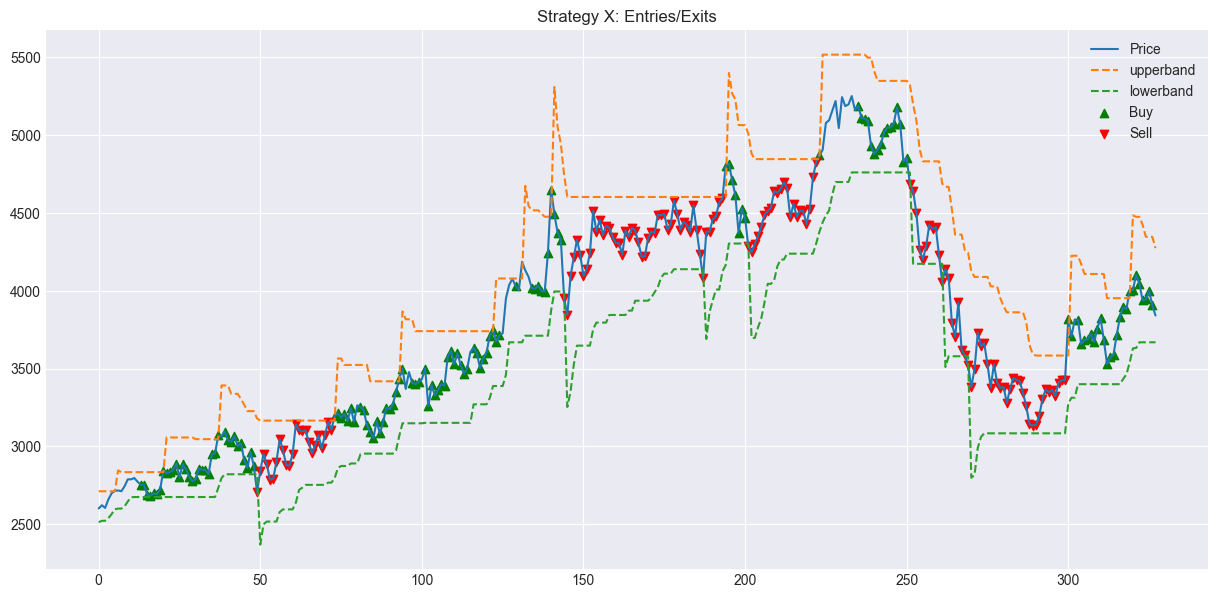

In [79]:
plt.figure(figsize=(15,7))
plt.plot(df['close'], label='Price')
plt.plot(df['upperband'], label='upperband', linestyle='--')
plt.plot(df['lowerband'], label='lowerband', linestyle='--')
plt.scatter(df[df['Signal'] == 1].index, 
            df[df['Signal'] == 1]['close'], 
            marker='^', color='g', label='Buy')
plt.scatter(df[df['Signal'] == -1].index, 
            df[df['Signal'] == -1]['close'], 
            marker='v', color='r', label='Sell')
plt.title('Strategy X: Entries/Exits')
plt.legend()
plt.show()


**4. Incorporating a Complementary Indicator:**

I am incorporating ATR that will bring in volatility into the play.

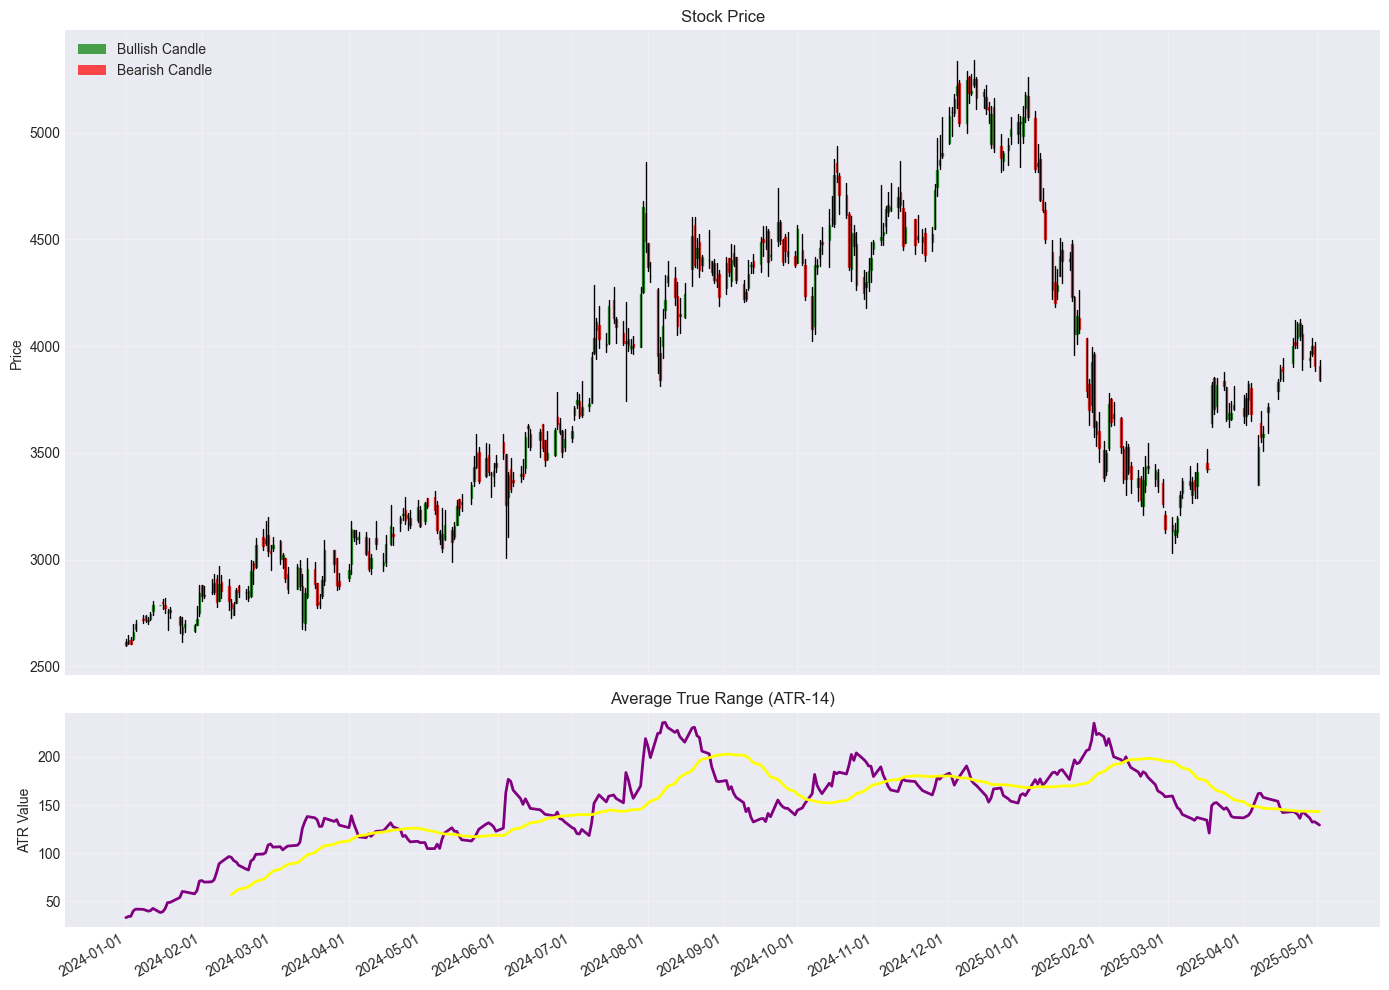

In [93]:
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle
def plot_stock_with_atr(df, atr_period=14):
    """
    Plot stock price data with candlesticks, volatility zones, and ATR.
    
    Parameters:
    - df: DataFrame with OHLC data and volatility zones
    - atr_period: Period for ATR calculation
    """
    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)
    
    # Format date axis
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax1.xaxis.set_major_locator(mdates.MonthLocator())
    
    # Plot candlestick chart
    for i, row in df.iterrows():
        # Determine candle color
        if row['close'] >= row['open']:
            color = 'green'
            body_bottom = row['open']
            body_height = row['close'] - row['open']
        else:
            color = 'red'
            body_bottom = row['close']
            body_height = row['open'] - row['close']
        
        # Plot candlestick body
        ax1.add_patch(Rectangle(
            (mdates.date2num(row['datetime'])-0.3, body_bottom),
            0.6, body_height, fill=True, color=color, alpha=0.7
        ))
        
        # Plot high/low wicks
        ax1.plot(
            [mdates.date2num(row['datetime']), mdates.date2num(row['datetime'])],
            [row['low'], row['high']],
            color='black', linewidth=1
        )
    # Plot ATR on the second subplot
    ax2.plot(df['datetime'], df['atr'], color='purple', linewidth=2)
    ax2.plot(df['datetime'], df['atr_ma'], color='yellow', linewidth=2)
    ax2.set_title(f'Average True Range (ATR-{atr_period})')
    ax2.grid(True, alpha=0.3)
    ax2.set_ylabel('ATR Value')
    
    # Set titles and labels
    ax1.set_title('Stock Price')
    ax1.set_ylabel('Price')
    ax1.grid(True, alpha=0.3)
    
    # Add a legend for candlesticks
    green_patch = plt.Rectangle((0, 0), 1, 1, fc="green", alpha=0.7)
    red_patch = plt.Rectangle((0, 0), 1, 1, fc="red", alpha=0.7)
    ax1.legend([green_patch, red_patch], ['Bullish Candle', 'Bearish Candle'], loc='upper left')
    
    # Format x-axis dates
    fig.autofmt_xdate()
    
    plt.tight_layout()
    plt.show()

plot_stock_with_atr(df, atr_period=14)

In [85]:
df['atr_ma'] = df['atr'].rolling(30).mean()
df.head()

,datetime,close,high,low,open,volume,HA_Close,HA_Open,HA_High,HA_Low,atr,upperband,lowerband,supertrend,supretrend,MFI,Signal,Return,Strategy_Return,atr_ma
0,2024-01-01,2601.022461,2629.011564,2595.915725,2611.334236,66066,2609.320997,2611.334236,2629.011564,2595.915725,33.095839,2711.751162,2513.176127,0,NaN,NaN,0,NaN,NaN,NaN
1,2024-01-02,2621.842529,2646.689046,2603.035911,2607.406092,143141,2619.743394,2610.327616,2646.689046,2603.035911,34.352914,2711.751162,2521.803737,0,0.0,NaN,0,0.008005,0.0,NaN
2,2024-01-03,2604.558350,2637.654193,2602.004862,2622.824781,112428,2616.760546,2615.035505,2637.654193,2602.004862,34.482555,2711.751162,2521.803737,0,0.0,NaN,0,-0.006592,-0.0,NaN
3,2024-01-04,2659.799805,2695.547197,2623.119251,2627.047546,268532,2651.378450,2615.898026,2695.547197,2615.898026,40.133185,2711.751162,2538.933670,0,0.0,NaN,0,0.021210,0.0,NaN
4,2024-01-05,2698.886230,2718.380493,2663.580723,2676.396835,354882,2689.311070,2633.638238,2718.380493,2633.638238,41.977935,2711.751162,2565.046803,0,0.0,NaN,0,0.014695,0.0,NaN


In [94]:
def strategy_y(data):
    # Existing Strategy X signals
    data['Signal'] = 0
    data.loc[(data['supertrend'] == 1) & (data['MFI'] < 80), 'Signal'] = 1
    data.loc[(data['supertrend'] == -1) & (data['MFI'] > 20), 'Signal'] = -1

    # Add ATR filter (only trade when ATR > ATR_MA)
    data['Signal'] = np.where(data['atr'] > data['atr_ma'], data['Signal'], 0)

    # Calculate returns
    data['Return'] = data['close'].pct_change()
    data['Strategy_Return_Y'] = data['Signal'].shift(1) * data['Return']
    total_return = data['Strategy_Return_Y'].sum() * 100
    win_rate = (data[data['Strategy_Return_Y'] > 0].shape[0] / 
               data[data['Strategy_Return_Y'] != 0].shape[0]) * 100
    
    print(f"Total Return: {total_return:.2f}%")
    print(f"Win Rate: {win_rate:.2f}%")

    return data
df = strategy_y(df)
df.head()

Total Return: -31.44%
Win Rate: 45.58%


,datetime,close,high,low,open,volume,HA_Close,HA_Open,HA_High,HA_Low,atr,upperband,lowerband,supertrend,supretrend,MFI,Signal,Return,Strategy_Return,atr_ma,Strategy_Return_Y
0,2024-01-01,2601.022461,2629.011564,2595.915725,2611.334236,66066,2609.320997,2611.334236,2629.011564,2595.915725,33.095839,2711.751162,2513.176127,0,NaN,NaN,0,NaN,NaN,NaN,NaN
1,2024-01-02,2621.842529,2646.689046,2603.035911,2607.406092,143141,2619.743394,2610.327616,2646.689046,2603.035911,34.352914,2711.751162,2521.803737,0,0.0,NaN,0,0.008005,0.0,NaN,0.0
2,2024-01-03,2604.558350,2637.654193,2602.004862,2622.824781,112428,2616.760546,2615.035505,2637.654193,2602.004862,34.482555,2711.751162,2521.803737,0,0.0,NaN,0,-0.006592,-0.0,NaN,-0.0
3,2024-01-04,2659.799805,2695.547197,2623.119251,2627.047546,268532,2651.378450,2615.898026,2695.547197,2615.898026,40.133185,2711.751162,2538.933670,0,0.0,NaN,0,0.021210,0.0,NaN,0.0
4,2024-01-05,2698.886230,2718.380493,2663.580723,2676.396835,354882,2689.311070,2633.638238,2718.380493,2633.638238,41.977935,2711.751162,2565.046803,0,0.0,NaN,0,0.014695,0.0,NaN,0.0


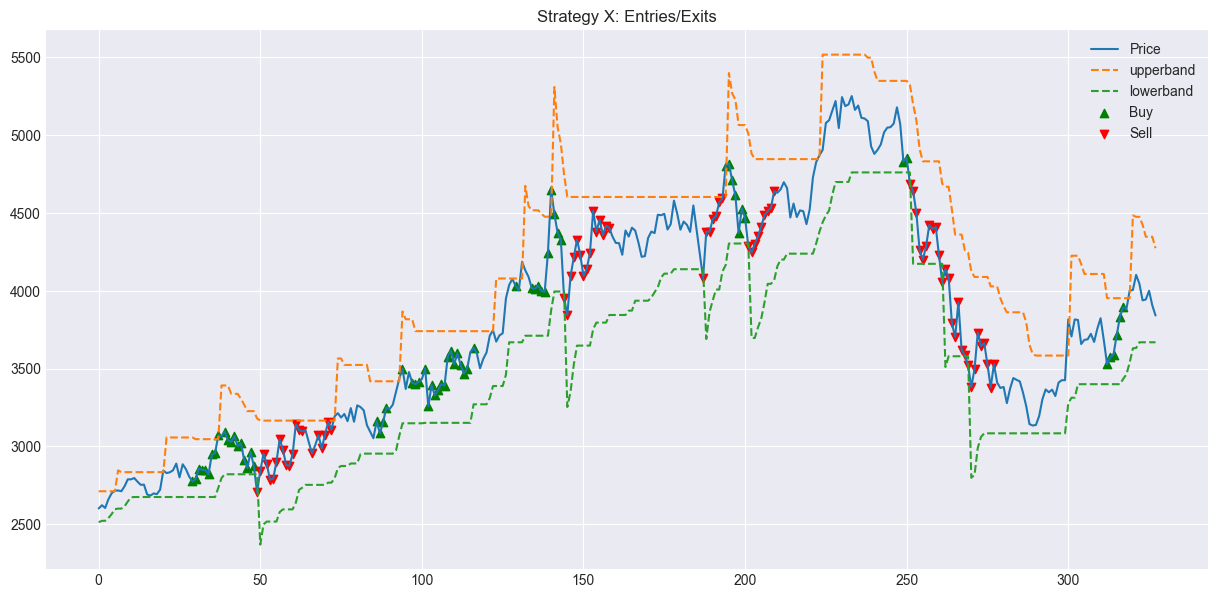

In [95]:
plt.figure(figsize=(15,7))
plt.plot(df['close'], label='Price')
plt.plot(df['upperband'], label='upperband', linestyle='--')
plt.plot(df['lowerband'], label='lowerband', linestyle='--')
plt.scatter(df[df['Signal'] == 1].index, 
            df[df['Signal'] == 1]['close'], 
            marker='^', color='g', label='Buy')
plt.scatter(df[df['Signal'] == -1].index, 
            df[df['Signal'] == -1]['close'], 
            marker='v', color='r', label='Sell')
plt.title('Strategy X: Entries/Exits')
plt.legend()
plt.show()


`ATR` prevents trades in low-volatility zones where signals are unreliable.
 Hence it complements Supertrend(trend) and MFI(momentum) with volatility context.

**5. Strategy Enhancements:**
- Identify market regimes (e.g., sideways, choppy, low-volume) where the strategy may
underperform or give false signals.
- Propose modifications to adapt the strategy for these regimes, considering time-frame
sensitivity, indicator tuning, or additional filters.

**Ans:**
- In sideways/choppy market regimes, supertrend may give false flips and also MFI can give wrong signals.
- In low-volume periods MFI loses much of its significance and hence singals becomes unreliable.
- Proposed modifications:
  - ATR bases volatility filter : We should not trade when ATR is low. This helps us avoid flat markets.
  - We can add a trend confirmation EMA filter, in which we go long when EMA is above 200, and short when EMA is below 200. This prevents us in doing countertrend trades.

### This assignment was **pretty challenging for me** as it involved a lots of indicators, so i have taken help from multiple sources as listed below:
- stackoverflow
- Implementation of indicators in python(wherever I got stuck) by some sites
- chatgpt to rectify errors at places